In [1]:
from huggingface_hub import login
from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein, SamplingConfig
from esm.utils.constants.models import ESM3_OPEN_SMALL
import tqdm
import numpy as np
from Bio import SeqIO
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
login(token="")

In [3]:
client = ESM3.from_pretrained(ESM3_OPEN_SMALL).to("cuda")
# client = ESM3.from_pretrained("esm3-open").to("cuda")

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
# Example:
proteins = [
    ESMProtein(
        sequence="MFVDDVTRAFESGDFARPNLFEVEISYLGQNFSFQCRATALPAAIVEKVPVSYMNRKINVAGDRTFDDWTITVMNDDAHSIRQKFVDWQGIAAGQGNEITGGKPAEYKKSAIVRQFARDAKTVTKEVEIVGLWPTNVGEVSLDWDSNNEIETFEVTLALDWWE"
    ),
    ESMProtein(
        sequence="MKFNILSLFAPWAKMDERDYKDQEKENLESITTPKLDDGAKEYEVSENEAQQTYNAMFQRMFGSQEPGLKSTRELIDTYRNLMTNYEVDNAVSEIVSDAIVYEDDTEVVSINLDNTKFSPNIKSMMLDEFNEVLNHLSFQRKGSDHFRRWYVDSRIFFHKIIDPKRPKEGIKELRRLDPRQVQYVREVITTTEAGVKIVKGYKEYFIYDTSHESYACDGRIYEAGTKIKIPKAAIVYAHSGLVDCCGKNIIGYLHRAIKPANQLKLLEDAVVIYRITRAPDRRVWYVDTGNMPSRKAAEHMQHVMNTMKNRIAYDATTGKIKNQQHIMSMTEDYWLQRRDGKAVTEVDTLPGADNTGNMEDVRWFRNALYMALRIPITRIPSDQGGIQFDAGTSITRDELSFGKFIRELQHKFEEIFLDPLKTNLILKGIITEDEWNDEINNIKIKFHRDSYFSELKDAEILERRINMLQMAEPFIGKYISHRTAMKDILQMSDEEIEQEAKQIEEESKEARFQDPDQEQEDF"
    ),
    ESMProtein(
        sequence="MDDLIQAIKSNDLVATRKFFESAMAEKTVRLIEARKAEIASQFLIEGEEPEEEEKKASEDDADEGDDDEDEDDEDDE"
    ),
]

outputs = []
for i, prot in enumerate(proteins):
    print(f"Protein: {i}")
    protein_tensor = client.encode(prot)
    outputs.append(
        client.forward_and_sample(
            protein_tensor,
            SamplingConfig(
                return_per_residue_embeddings=True, return_mean_embedding=True
            ),
        )
    )

Protein: 0
Protein: 1
Protein: 2
[tensor([ -59.9508,  -37.9864,  -36.9680,  ..., -126.9061,   50.3665,
          17.2420], device='cuda:0'), tensor([ 67.2142, -37.2189,   0.8386,  ...,  18.7646,   6.6657, -11.0285],
       device='cuda:0'), tensor([ 55.4066,  -2.5047,   5.4925,  ...,  56.6044, 108.8006, -73.5783],
       device='cuda:0')]


In [4]:
# Import BASEL proteins
df = pd.read_csv("./data/basel_structure_reps.csv")

print(df.head)

<bound method NDFrame.head of                                                      id  \
0     MZ501068.1_prot_QXV79352.1_87_unknown_LYR_moti...   
1          MZ501068.1_prot_QXV79354.1_89_known_o-spanin   
2     MZ501069.1_prot_QXV79378.1_21_known_tail_assem...   
3     MZ501069.1_prot_QXV79415.1_58_unknown_ABC_tran...   
4     MZ501069.1_prot_QXV79417.1_60_unknown_MARVEL_d...   
...                                                 ...   
1168  NC_001895.1_prot_NP_046793.1_38_known_DksA-lik...   
1169  NC_001895.1_prot_NP_046794.1_39_known_DUF5405_...   
1170  NC_001895.1_prot_NP_046795.1_40_known_nicking_...   
1171  NC_001895.1_prot_NP_046796.1_41_known_DUF3850_...   
1172          NC_001895.1_prot_NP_046797.1_42_known_Tin   

                                               sequence  
0     MSDTTNAQLAAARVYMRGAAAEIDALPQFEKHVQQLEHKFKALKDL...  
1     MRKTLSNVSTDLVLNLWLPILIIIVLLMTGCTTKSQPSVSTSVTLP...  
2     MTLKVIKLSGSLGRRFGVFHKMAVDSYPEAIRALSSQVEGFKDYMQ...  
3     MSVVANQKAIDQTNDKRFAIFIT

In [5]:
# Calculate protein sequence embeddings and save them as npy files


def get_esm_embedding(sequence):
    protein = ESMProtein(sequence=sequence)
    protein_tensor = client.encode(protein)

    result = client.forward_and_sample(
        protein_tensor,
        SamplingConfig(return_per_residue_embeddings=True, return_mean_embedding=True),
    )

    return result


def process_sequences(df):
    ids = []
    embeddings = []

    for index, row in tqdm.tqdm(
        df.iterrows(), total=len(df), desc="Processing protein sequences"
    ):
        seq = row["sequence"]
        protein_id = row["id"]

        seq = seq[:300]  # Limit protein length
        embedding = get_esm_embedding(seq)
        ids.append(protein_id)
        embeddings.append(embedding)

    np.save("esm_embedding_protein_ids_basel.npy", np.array(ids))
    np.save("esm_embedding_embeddings_basel.npy", np.array(embeddings))


process_sequences(df)

Processing protein sequences: 100%|██████████| 1173/1173 [1:56:01<00:00,  5.93s/it] 


In [ ]:
# Load embeddings and get mean embeddings per residue (?)
mean_embeddings = []
esm_embeddings = np.load("esm_embedding_embeddings_basel.npy", allow_pickle=True)
mean_embeddings = [ebd.mean_embedding.cpu() for ebd in esm_embeddings]

# print(esm_embeddings[0])

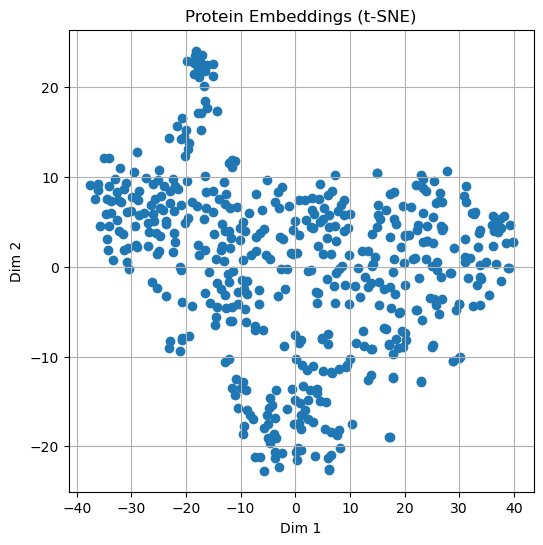

In [15]:
# Plot protein sequence embeddings

# Stack and convert to numpy array
stack_mean_embeddings = torch.stack([emb for emb in mean_embeddings]).numpy()

# t-SNE
perplexity = min(30, stack_mean_embeddings.shape[0] - 1)
tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    learning_rate="auto",
    random_state=42,
)
reduced = tsne.fit_transform(stack_mean_embeddings)  # Shape: (N, 2)
# print(reduced.shape)

# tsne Plot
plt.figure(figsize=(6, 6))
plt.scatter(reduced[:, 0], reduced[:, 1])

plt.title("Protein Embeddings (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

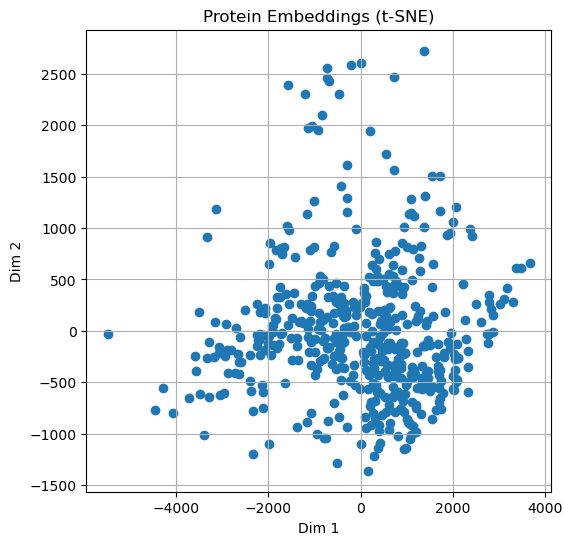

In [14]:
# PCA plot
pca = PCA(n_components=2)
components = pca.fit_transform(stack_mean_embeddings)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(components[:, 0], components[:, 1])

plt.title("Protein Embeddings (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()


In [ ]:
import umap